_ColormakerRegistry()

[utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.
[tautomers.py:327 - _perform_tautomer_transformation()] Index of atom that moves: 11.
[tautomers.py:339 - _perform_tautomer_transformation()] Index of atom that donates hydrogen: 2
[tautomers.py:357 - _perform_tautomer_transformation()] Index of atom that accepts hydrogen: 5


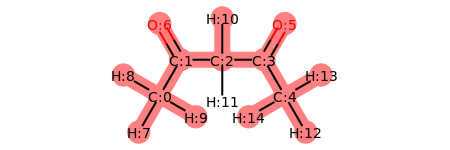

[restraints.py:158 - __init__()] Center Of Mass restraint added.
  0%|          | 3/1000 [00:00<00:49, 20.16it/s, |force|=4.98e+3]

0.0


 10%|▉         | 97/1000 [00:04<00:45, 19.83it/s, |force|=4.9e+3] 

KeyboardInterrupt: 

In [1]:
from simtk import unit
import numpy as np
from tqdm import tqdm
import mdtraj as md
import nglview
from rdkit import Chem
from rdkit.Chem import AllChem
import neutromeratio
import matplotlib.pyplot as plt
import pickle
import torchani
import torch
from neutromeratio.constants import device, platform
from neutromeratio.restraints import CenterOfMassRestraint

exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


# number of steps
n_steps = 1000

exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
tautomer = neutromeratio.Tautomer(name=name, intial_state_mol=neutromeratio.generate_rdkit_mol(t1_smiles), final_state_mol=neutromeratio.generate_rdkit_mol(t2_smiles), nr_of_conformations=20)
tautomer.perform_tautomer_transformation_forward()
#m = tautomer.add_droplet(tautomer.hybrid_topology, tautomer.hybrid_coords, diameter=15 * unit.angstrom)

# define the alchemical atoms
alchemical_atoms=[tautomer.hybrid_hydrogen_idx_at_lambda_1, tautomer.hydrogen_idx]

# extract hydrogen donor idx and hydrogen idx for from_mol
model = neutromeratio.ani.LinearAlchemicalDualTopologyANI(alchemical_atoms=alchemical_atoms)
model = model.to(device)

# perform initial sampling
energy_function = neutromeratio.ANI1_force_and_energy(
                                        model = model,
                                        atoms = tautomer.hybrid_atoms,
                                        mol = tautomer.hybrid_ase_mol,
                                        )

tautomer.add_COM_for_hybrid_ligand(np.array([0., 0., 0.]) * unit.angstrom)

for r in tautomer.ligand_restraints:
    energy_function.add_restraint(r)

for r in tautomer.hybrid_ligand_restraints:
    energy_function.add_restraint(r)
    
for r in tautomer.com_restraints:
    energy_function.add_restraint(r)

        
trajectory = []
bias_list = []
lambda_value = 0.0
print(lambda_value)
energy_and_force = lambda x : energy_function.calculate_force(x, lambda_value)
langevin = neutromeratio.LangevinDynamics(atoms = tautomer.hybrid_atoms,
                            temperature = 300*unit.kelvin,
                            energy_and_force = energy_and_force)

x0 = tautomer.hybrid_coords
#x0 = energy_function.minimize(x0)

equilibrium_samples, energies, bias = langevin.run_dynamics(x0, n_steps=n_steps, stepsize=0.5 * unit.femtosecond, progress_bar=True)
bias_list.append(bias)
trajectory.append(equilibrium_samples)


In [1]:
traj_in_nm = [x.value_in_unit(unit.nanometer) for x in trajectory[idx]]
import nglview
ani_traj = md.Trajectory(traj_in_nm[::20], tautomer.ligand_in_water_topology)
v = neutromeratio.vis.generate_nglview_object(ani_traj)
v.add_representation(repr_type='ball+stick', selection='water', opacity=0.4, color='blue')
v.shape.add_sphere([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2], [0,0,1], diameter_in_angstrom/2-1)
v.update_representation(component=1, repr_index=0, opacity=0.2)
v

NameError: name 'trajectory' is not defined